In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

In [2]:
# load data 
def get_data(target):
    target = target.upper()
    df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
    
    # Prediction O/U
    if(target == 'OU_RESULT'): # Classification
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        task = 'classification'
    if(target == 'OU_LINE'): # Regression
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        df['OU_LINE'] = df['ou_line']
        df['FINAL_OU'] = df['score1'] + df['score2']
        task = 'regression'
        target = 'FINAL_OU'
        
    if('OU' in target):
        df = df.dropna(subset=[target])
        df = df[df['OU_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['OU_LINE', 'OU_RESULT']
        
    if(target == 'SPREAD_RESULT'): # Classification
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        task = 'classification'
    if(target == 'SPREAD'): # Regression
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        df['SPREAD'] = df['spread']
        df['FINAL_SPREAD'] = df['score1'] - df['score2']
        task = 'regression'
        target = 'FINAL_SPREAD'

    if('SPREAD' in target):
        df = df.dropna(subset=[target])
        df = df[df['SPREAD_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['SPREAD', 'SPREAD_RESULT']
    
    return df, target.upper(), outcome, task


In [3]:
def get_columns(df, target):
    game_data_columns = []
    for c in df.columns:
        if("home" in c or "away" in c or 'elo' in c):
            #if('td' not in c and 'xp' not in c and 'fg' not in c and 'poss' not in c and 'down' not in c and target not in c and 'post' not in c):
            if('poss' not in c and 'down' not in c and target not in c and 'post' not in c):
                game_data_columns.append(c)

    return df[game_data_columns]

In [4]:
# Create a dataset that pytorch loader can work with 
class NFLClassificationDataset(Dataset):
    def __init__(self, dataframe, target, features, task='classification', outcome=None):
        self.features = features
        self.target = target
        if(task == 'classification'):
            self.y = torch.tensor(dataframe[target].values).long()
            self.outcome = torch.tensor(dataframe[target].values).long()
        else:
            self.y = torch.tensor(dataframe[target].values).float()
            self.outcome = torch.tensor(dataframe[outcome].values).float()

        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
def split_data(df, target, task, year=2020, outcome=None):
    '''
        Uses single year as validaion year. Previous years are train, future years are test
    '''
    df_train = benchmark_data[df['year'] <= year].copy()
    df_val = benchmark_data[df['year'] == year].copy()
    df_test = benchmark_data[df['year'] > year].copy()
    
    df_train[target] = df[df['year'] < year][target]
    df_val[target] = df[df['year'] == year][target]
    df_test[target] = df[df['year'] > year][target]

    for c in df_train.columns:
        if(task == 'classification' and c == target):
            continue
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_val[c] = (df_val[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
    
    df_train = df_train.dropna(subset=[target])
    df_val = df_val.dropna(subset=[target])
    df_test = df_test.dropna(subset=[target])
    
    if(outcome is not None):
        df_train[outcome] = df[df['year'] < year][outcome]
        df_val[outcome] = df[df['year'] == year][outcome]
        df_test[outcome] = df[df['year'] > year][outcome]
        
        mean = df_train[outcome[0]].mean()
        std = df_train[outcome[0]].std()
        
        df_train[outcome[0]] = (df_train[outcome[0]] - mean)/std
        df_val[outcome[0]] = (df_val[outcome[0]] - mean)/std
        df_test[outcome[0]] = (df_test[outcome[0]] - mean)/std

    
    return df_train, df_val, df_test

def get_data_loaders(df_train, df_val, df_test, target, task, batch_size=32, outcome=None):
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features, task=task, outcome=outcome)
    val_dataset = NFLClassificationDataset(df_val, target=target, features=features, task=task, outcome=outcome)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features, task=task, outcome=outcome)
    
    # Set the dataset in pytorch dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [6]:
# Training 
def train(data, model, loss_func, optimizer, task):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        if(task=='classification'):
            loss = loss_func(output, y)
        if(task=='regression'):
            loss = loss_func(output, y[:,np.newaxis])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    return mean_loss, model
    

def test(data, model, loss_func, task):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output = model(x)
            if(task == 'classification'):
                total_loss += loss_func(output,y).item()
            else:
                total_loss += loss_func(output,y[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    
    return mean_loss   

# prediction function
def predict(data, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    return output

In [7]:
def evaluate(data, model):
    preds, labels = torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        for x, y in data:
            labels = torch.cat((labels, y))
            preds = torch.cat((preds, torch.argmax(model(x[np.newaxis]), dim=2)[0]))            
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

def classification_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        for x, y in test_loader:
            pred = model(x)
            pred_label = torch.argmax(model(x), dim=1)
            for i in range(len(pred)):
                if(pred[i][pred_label[i]] > threshold):
                    if(pred_label[i] == y[i]):
                        good_bet += 1
                        money += 90.91
                    else:
                        bad_bet += 1
                        money -= 100
                total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games


def regression_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        preds, ou_preds = torch.Tensor([]), torch.Tensor([])
        
        # Get predictions
        for x, y in test_loader:
            pred = model(x)
            preds = torch.cat((preds, pred[:,0]))

        # Check if prediction is bigger or smaller than line
        outcome = test_loader.dataset.outcome
        meets_threshold, ou_preds = [], []
        for i in range(len(preds)):
            meets_threshold.append((preds[i] - outcome[i][0]).abs() > threshold)
            ou_preds.append(preds[i] > outcome[i][0])

        for i in range(len(ou_preds)):
            if(meets_threshold[i]):
                if(ou_preds[i] == outcome[i][1]):
                    good_bet += 1
                    money += 90.91
                else:
                    bad_bet += 1
                    money -= 100
            total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games

## Put it all together

311 8 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.78it/s]


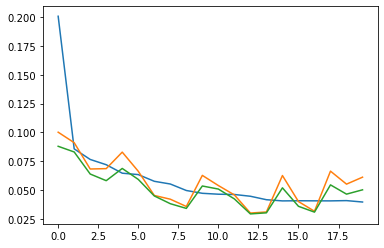

THRESHOLD: 1.0
GOOD BETS: 66	BAD BETS: 65
MONEY MADE: -499.94 BETTING ON 53.47% OF GAMES


In [8]:
# Get data    
target = 'ou_line'
df, target, outcome, task = get_data(target)
benchmark_data = get_columns(df, target)

df_train, df_val, df_test = split_data(df, target, task, outcome=outcome)
df_train = df_train.dropna()

train_loader, val_loader, test_loader = get_data_loaders(
                                            df_train,
                                            df_val,
                                            df_test, 
                                            target,
                                            task,
                                            batch_size=32,
                                            outcome=outcome)

thresholds = np.linspace(0.5, 1.0, 51)
money_made = []
games_bet = []

# hyperparameters
lr = 1e-3
epoch = 20
input_size = len(list(df_train.columns.difference([target])))
hidden_size = 64
dropout = 0.2

if(task == 'classification'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,2),
        nn.Softmax(dim=1)
    )
    loss_func = nn.CrossEntropyLoss()
elif(task == 'regression'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,1),
    )
    loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Run lstm 
trainloss = []
testloss = []
valloss = []
print(len(train_loader), len(val_loader), len(test_loader))
for i in tqdm(range(epoch)):
    train_loss, model = train(train_loader, model, loss_func, optimizer=optimizer, task=task)
    trainloss.append(train_loss)

    val_loss = test(val_loader, model, loss_func, task=task)
    valloss.append(val_loss)

    test_loss  = test(test_loader, model, loss_func, task=task)
    testloss.append(test_loss)    

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(valloss)
ax.plot(testloss)
plt.show()

if(task == 'classification'):
    val_accuracy = evaluate(val_loader, model)
    test_accuracy = evaluate(test_loader, model)
    result = classification_betting_result(model, val_loader, threshold=0.7)
    money_made.append(result[0])
    games_bet.append(result[1])
elif(task == 'regression'):
    result = regression_betting_result(model, val_loader, threshold=1.)
    money_made.append(result[0])
    games_bet.append(result[1])
        
#fig, ax = plt.subplots(ncols=2, figsize=(15,6))
#ax[0].plot(thresholds, money_made)
#ax[1].plot(thresholds, games_bet)
#plt.show()

## LSTM 

In [55]:
# load data 
def get_lstm_data(target):
    target = target.upper()
    df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
    df = df[df['season'] >= 1979]

    # Prediction O/U
    if(target == 'OU_RESULT'): # Classification
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        task = 'classification'
    if(target == 'OU_LINE'): # Regression
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        df['OU_LINE'] = df['ou_line']
        df['FINAL_OU'] = df['score1'] + df['score2']
        task = 'regression'
        target = 'FINAL_OU'
        
    if('OU' in target):
        df = df.dropna(subset=[target])
        df = df[df['OU_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['OU_LINE', 'OU_RESULT']
        
    if(target == 'SPREAD_RESULT'): # Classification
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        task = 'classification'
    if(target == 'SPREAD'): # Regression
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        df['SPREAD'] = df['spread']
        df['FINAL_SPREAD'] = df['score1'] - df['score2']
        task = 'regression'
        target = 'FINAL_SPREAD'

    if('SPREAD' in target):
        df = df.dropna(subset=[target])
        df = df[df['SPREAD_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['SPREAD', 'SPREAD_RESULT']
        
    return df, target.upper(), outcome, task

In [10]:
class NFLSingleTeamData(Dataset):
    def __init__(self, dataframe, target, features, task='classification', outcome=None):
        self.features = features
        self.target = target
        self.index = dataframe.index
        if(task == 'classification'):
            self.y = torch.tensor(dataframe[target].values).long()
            self.outcome = torch.tensor(dataframe[target].values).long()
        else:
            self.y = torch.tensor(dataframe[target].values).float()
            self.outcome = torch.tensor(dataframe[outcome].values).float()

        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [11]:
# model 
class SeasonRegressionLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super(SeasonRegressionLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size, 
                            num_layers = self.num_layers, 
                            dropout = self.dropout, 
                            batch_first = True).cuda()
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=output_size).cuda()
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().cuda()
        
        outs, (hn, cn) = self.lstm(x,(h0,c0))
        out = self.linear(outs)
        if(out.shape[1] == 2):
            out = nn.Softmax(dim=1)(out)
        
        return out 

In [12]:
def split_lstm_data(df, target, task, year=2020, outcome=None):
    '''
        Uses single year as validaion year. Previous years are train, future years are test
    '''
    df_train = benchmark_data[df['season'] <= year].copy()
    df_val = benchmark_data[df['season'] == year].copy()
    df_test = benchmark_data[df['season'] > year].copy()
    
    df_train[target] = df[df['season'] < year][target]
    df_val[target] = df[df['season'] == year][target]
    df_test[target] = df[df['season'] > year][target]

    for c in df_train.columns:
        if(task == 'classification' and c == target):
            continue
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_val[c] = (df_val[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
    
    df_train = df_train.dropna(subset=[target])
    df_val = df_val.dropna(subset=[target])
    df_test = df_test.dropna(subset=[target])
    
    if(outcome is not None):
        df_train[outcome] = df[df['season'] < year][outcome]
        df_val[outcome] = df[df['season'] == year][outcome]
        df_test[outcome] = df[df['season'] > year][outcome]
        
        mean = df_train[outcome[0]].mean()
        std = df_train[outcome[0]].std()
        
        df_train[outcome[0]] = (df_train[outcome[0]] - mean)/std
        df_val[outcome[0]] = (df_val[outcome[0]] - mean)/std
        df_test[outcome[0]] = (df_test[outcome[0]] - mean)/std

    
    return df_train, df_val, df_test


def _shift_one_week(team_season, target):
    N = len(team_season)
    shifted = np.empty(N)
    shifted[:] = np.nan
    shifted[:N-1] = team_season[target][1:]
    team_season[target] = shifted
    return team_season.dropna()


def get_lstm_data_loaders(df, df_train, df_val, df_test, target, task, batch_size=4, outcome=None, year=2020):
    features = list(df_train.columns.difference([target]))
    train_data, val_data, test_data = [], [], []
    for season, games in df.groupby("season"):
        # Need each team's games for each season, which becomes an NFLSingleTeamData object
        # Need to shift data by 1 game here.
        for team in games['team1'].unique():
            if(season < year):
                team_season = df_train.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                team_season = _shift_one_week(team_season, target)
                train_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
            elif(season == year):
                team_season = df_val.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                team_season = _shift_one_week(team_season, target)
                val_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
            else:
                team_season = df_test.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                team_season = _shift_one_week(team_season, target)
                test_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
                
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_data, val_data, test_data

In [13]:
# Training 
def train_lstm(data, model, loss_func, optimizer, task):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for d in data:
        output = model(d.X.cuda())
        if(task=='classification'):
            loss = loss_func(output, d.y.cuda())
        if(task=='regression'):
            loss = loss_func(output, d.y[:,np.newaxis].cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    return mean_loss, model
    

def test_lstm(data, model, loss_func, task):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for d in data:
            output = model(d.X.cuda())
            if(task == 'classification'):
                total_loss += loss_func(output,d.y.cuda()).item()
            else:
                #total_loss += loss_func(output,d.y[:,np.newaxis]).item()
                total_loss += loss_func(output,d.y.cuda()[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    
    return mean_loss   

# prediction function
def predict_lstm(data, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for d in data:
            #y_fit = model(d.X).detach()
            y_fit = model(d.X.cuda()).detach()
            output = torch.cat((output,y_fit), 0)
    return output

In [14]:
def evaluate_lstm(data, model):
    preds, labels = torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        for d in data:
            labels = torch.cat((labels, d.y))
            #preds = torch.cat((preds, torch.argmax(model(d.X), dim=1)))            
            preds = torch.cat((preds, torch.argmax(model(d.X.cuda()).cpu(), dim=1)))            
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

def classification_betting_result_lstm(model, test_loader, df, threshold=0.6, verbose=False):
    # Need to filter out duplicates somehow
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        
        all_pred_labels, all_ys, all_indices = [], [], []
        for d in test_loader:
            # Get prediction and label
            pred = model(d.X.cuda()).cpu()
            pred_label = torch.argmax(model(d.X.cuda()).cpu(), dim=1)
            #pred = model(d.X).cpu()
            #pred_label = torch.argmax(model(d.X).cpu(), dim=1)
            
            # Hold on to prediction/data if above threshold
            for idx in range(len(pred)):
                total_games += 1
                if(pred[idx][pred_label[idx]] > threshold):
                    all_pred_labels.append(float(pred_label[idx]))
                    all_ys.append(float(d.y[idx]))
                    all_indices.append(float(d.index[idx]))
                    
        # Match make_bet between games predicted from each team
        pred_dict = {}
        pred_ys = {}
        for i in range(len(all_pred_labels)):
            if(all_indices[i] not in pred_dict):
                pred_dict[all_indices[i]] = [all_pred_labels[i]]
            else:
                pred_dict[all_indices[i]].append(all_pred_labels[i])
                
            if(all_indices[i] not in pred_ys):
                pred_ys[all_indices[i]] = [all_ys[i]]
            else:
                pred_ys[all_indices[i]].append(all_ys[i])
        
        times_half_good_bet = 0
        for i in range(len(all_pred_labels)):
            # Don't bet on games with opposite predictions
            if(len(pred_dict[all_indices[i]]) == 2 and sum(pred_dict[all_indices[i]]) == 1):
                continue          
            if(len(pred_ys[all_indices[i]]) == 2 and sum(pred_ys[all_indices[i]]) == 1):
                continue
            
            # Make Bets
            if(all_pred_labels[i] == all_ys[i]):
                if(len(pred_dict[all_indices[i]]) == 2):
                    good_bet += 1/2
                    money += 90.91/2
                    times_half_good_bet += 1
                else:
                    good_bet += 1
                    money += 90.91
            else:
                if(len(pred_dict[all_indices[i]]) == 2):
                    bad_bet += 1/2
                    money -= 100/2
                else:
                    bad_bet += 1
                    money -= 100
    if(verbose):
        print("THRESHOLD: {0:.2f}".format(threshold))
        print("TIMES HALF GOOD BET: {}".format(times_half_good_bet))
        print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
        print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games


def regression_betting_result_lstm(model, test_loader, df, threshold=0.6):
    # Need to filter out duplicates somehow
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        preds, ou_preds = torch.Tensor([]), torch.Tensor([])
        all_indices = []
        
        # Get predictions
        for d in test_loader:
            pred = model(d.X.cuda()).cpu()
            preds = torch.cat((preds, pred[:,0]))
            for i in range(len(pred)):
                all_indices.append(d.index[i])
                total_games += 1

        # Check if prediction is bigger or smaller than line
        outcome = torch.Tensor([])
        for d in test_loader:
            outcome = torch.cat((outcome, d.outcome))

        meets_threshold, ou_preds = [], []
        for i in range(len(preds)):
            meets_threshold.append(bool((preds[i] - outcome[i][0]).abs() > threshold))
            ou_preds.append(int(preds[i] > outcome[i][0]))
            
        meets_threshold = np.array(meets_threshold)
        ou_preds = np.array(ou_preds)[meets_threshold]
        all_indices = np.array(all_indices)[meets_threshold]
        preds = preds[meets_threshold]
        outcome = outcome[meets_threshold]
            
        # Match make_bet between games predicted from each team
        pred_dict = {}
        pred_ys = {}
        for i in range(len(ou_preds)):
            if(all_indices[i] not in pred_dict):
                pred_dict[all_indices[i]] = [preds[i]]
            else:
                pred_dict[all_indices[i]].append(preds[i])
                
            if(all_indices[i] not in pred_ys):
                pred_ys[all_indices[i]] = [outcome[i][1].item()]
            else:
                pred_ys[all_indices[i]].append(outcome[i][1].item())
                
        #print(pred_ys)
        # Do bets
        for i in range(len(ou_preds)):
            if(len(pred_dict[all_indices[i]]) == 2 and sum(pred_dict[all_indices[i]]) == 1):
                continue
            if(len(pred_ys[all_indices[i]]) == 2 and sum(pred_ys[all_indices[i]]) == 1):
                continue

            #print(ou_preds[i], outcome[i][1])
            if(ou_preds[i] == outcome[i][1]):
                if(len(pred_ys[all_indices[i]]) == 2):
                    good_bet += 1/2
                    money += 90.91/2
                else:
                    good_bet += 1
                    money += 90.91
            else:
                if(len(pred_ys[all_indices[i]]) == 2):
                    bad_bet += 1
                    money -= 100
                else:
                    bad_bet += 1
                    money -= 100
            #total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games

Index(['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'qbelo1_pre',
       'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2', 'home_pass_cmp',
       'home_pass_att', 'home_pass_yds', 'home_pass_td', 'home_pass_int',
       'home_pass_sacked', 'home_pass_sacked_yds', 'home_pass_yds_per_att',
       'home_pass_net_yds_per_att', 'home_pass_cmp_perc', 'home_pass_rating',
       'home_rush_att', 'home_rush_yds', 'home_rush_yds_per_att',
       'home_rush_td', 'home_fgm', 'home_fga', 'home_xpm', 'home_xpa',
       'home_punt', 'home_punt_yds', 'away_pass_cmp', 'away_pass_att',
       'away_pass_yds', 'away_pass_td', 'away_pass_int', 'away_pass_sacked',
       'away_pass_sacked_yds', 'away_pass_yds_per_att',
       'away_pass_net_yds_per_att', 'away_pass_cmp_perc', 'away_pass_rating',
       'away_rush_att', 'away_rush_yds', 'away_rush_yds_per_att',
       'away_rush_td', 'away_fgm', 'away_fga', 'away_xpm', 'away_xpa',
       'away_punt', 'away_punt_yds', 'FINAL_SPREAD', 'SPREAD',
       'SPREAD

100%|██████████████████████████████████████████████████████████████| 200/200 [11:48<00:00,  3.54s/it]


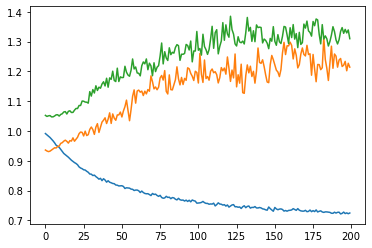

In [80]:
# Get data
target = 'spread' # One of: spread, spread_result, ou_line, ou_result
df, target, outcome, task = get_lstm_data(target)
benchmark_data = get_columns(df, target)

df_train, df_val, df_test = split_lstm_data(df, target, task, outcome=outcome)
#print(df_train.columns)
#raise
df_train = df_train.dropna()
print(df_train.columns)

train_loader, val_loader, test_loader = get_lstm_data_loaders(
                                            df,
                                            df_train,
                                            df_val,
                                            df_test, 
                                            target,
                                            task,
                                            batch_size=1,
                                            outcome=outcome)

# hyperparameters
lr = 1e-3
epoch = 200
input_size = len(df_train.columns)-1
hidden_size = 16
num_layers = 3
dropout = 0.2

model = SeasonRegressionLSTM(
                       input_size=input_size,
                       output_size=1 if(task == 'regression') else 2,
                       hidden_size=hidden_size, 
                       num_layers= num_layers,
                       dropout= dropout
                      ).cuda()
loss_func = nn.CrossEntropyLoss() if(task == 'classification') else nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Run lstm 
trainloss = []
testloss = []
valloss = []
print(len(train_loader), len(val_loader), len(test_loader))
for i in tqdm(range(epoch)):
    train_loss, model = train_lstm(train_loader, model, loss_func, optimizer=optimizer, task=task)
    trainloss.append(train_loss)

    val_loss = test_lstm(val_loader, model, loss_func, task=task)
    valloss.append(val_loss)

    test_loss  = test_lstm(test_loader, model, loss_func, task=task)
    testloss.append(test_loss)    

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(valloss)
ax.plot(testloss)
plt.show()


THRESHOLD: 0.9
GOOD BETS: 60.0	BAD BETS: 134
MONEY MADE: -7945.40 BETTING ON 38.80% OF GAMES

THRESHOLD: 0.982
GOOD BETS: 54.0	BAD BETS: 127
MONEY MADE: -7790.86 BETTING ON 36.20% OF GAMES

THRESHOLD: 1.064
GOOD BETS: 48.0	BAD BETS: 113
MONEY MADE: -6936.32 BETTING ON 32.20% OF GAMES

THRESHOLD: 1.146
GOOD BETS: 45.0	BAD BETS: 106
MONEY MADE: -6509.05 BETTING ON 30.20% OF GAMES

THRESHOLD: 1.228
GOOD BETS: 43.0	BAD BETS: 98
MONEY MADE: -5890.87 BETTING ON 28.20% OF GAMES

THRESHOLD: 1.31
GOOD BETS: 40.0	BAD BETS: 90
MONEY MADE: -5363.60 BETTING ON 26.00% OF GAMES

THRESHOLD: 1.392
GOOD BETS: 38.0	BAD BETS: 81
MONEY MADE: -4645.42 BETTING ON 23.80% OF GAMES

THRESHOLD: 1.474
GOOD BETS: 33.0	BAD BETS: 71
MONEY MADE: -4099.97 BETTING ON 20.80% OF GAMES

THRESHOLD: 1.556
GOOD BETS: 28.0	BAD BETS: 63
MONEY MADE: -3754.52 BETTING ON 18.20% OF GAMES

THRESHOLD: 1.638
GOOD BETS: 24.0	BAD BETS: 59
MONEY MADE: -3718.16 BETTING ON 16.60% OF GAMES

THRESHOLD: 1.7199999999999998
GOOD BETS: 23.0	BA

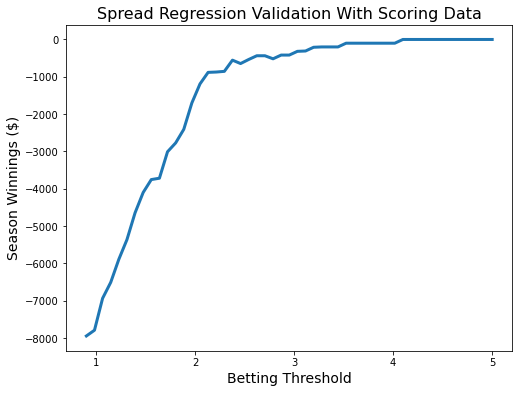



TEST
THRESHOLD: 4.098
GOOD BETS: 0	BAD BETS: 0
MONEY MADE: 0.00 BETTING ON 0.00% OF GAMES
0.7248345505485346 1.3097321996465325


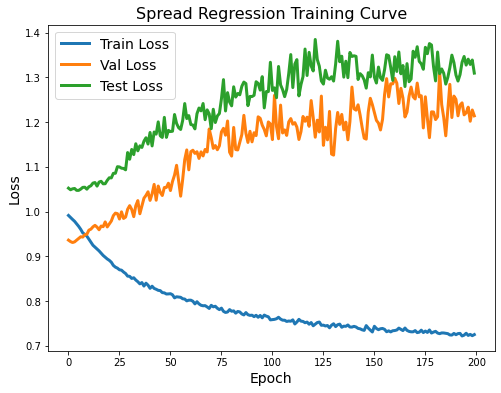

In [82]:
if(task == 'classification'):
    print("CLASSIFICATION")
    most_money = -9999999999
    best_threshold = 0
    train_accuracy = evaluate_lstm(train_loader, model)
    val_accuracy = evaluate_lstm(val_loader, model)
    test_accuracy = evaluate_lstm(test_loader, model)
    moneys = []
    for t in np.linspace(0.5, 1.0, 51):
        result = classification_betting_result_lstm(model, test_loader, df, threshold=t)
        moneys.append(result[0])
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print("\nTEST DATASET:")
    print("BEST MONEY ON VALIDATION: {0:.2f} WITH THRESHOLD: {1:.2f}".format(most_money, best_threshold))
    result = classification_betting_result_lstm(model, val_loader, df, threshold=best_threshold, verbose=True)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(np.linspace(0.5, 1.0, 51), moneys, lw=3)
    ax.set_xlabel("Betting Threshold", fontsize=14)
    ax.set_ylabel("Season Winnings ($)", fontsize=14)
    ax.set_title("Spread Classification Validation With Scoring Data", fontsize=16)
    plt.show()
elif(task=='regression'):
    most_money = -9999999999
    best_threshold = 0
    moneys = []
    for t in np.linspace(0.9, 5, 51):
        print()
        result = regression_betting_result_lstm(model, val_loader, df, threshold=t)
        moneys.append(result[0])
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print(most_money, best_threshold)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(np.linspace(0.9, 5, 51), moneys, lw=3)
    ax.set_xlabel("Betting Threshold", fontsize=14)
    ax.set_ylabel("Season Winnings ($)", fontsize=14)
    ax.set_title("Spread Regression Validation With Scoring Data", fontsize=16)
    plt.show()
    
    print("\n\nTEST")
    result = regression_betting_result_lstm(model, test_loader, df, threshold=best_threshold)
    money_made.append(result[0])
    games_bet.append(result[1])
    
print(trainloss[-1], testloss[-1])
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(trainloss, label="Train Loss", lw=3)
ax.plot(valloss, label="Val Loss", lw=3)
ax.plot(testloss, label="Test Loss", lw=3)
ax.legend(loc='best', fontsize=14)
ax.set_title("Spread Regression Training Curve", fontsize=16)
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
plt.show()

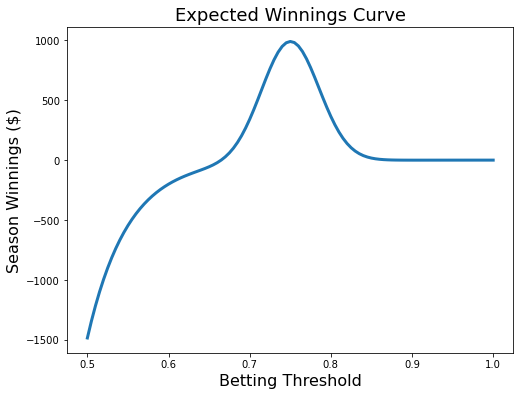

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
xs = np.linspace(-5, 5, 101)
ax.plot(np.linspace(0.5, 1, 101), 1000*(np.exp(-xs**2)-0.01*np.exp(-xs)), lw=3)
ax.set_title("Expected Winnings Curve", fontsize=18)
ax.set_xlabel("Betting Threshold", fontsize=16)
ax.set_ylabel("Season Winnings ($)", fontsize=16)
plt.savefig("./expected_winings.png")
plt.show()

In [31]:
if(task == 'classification'):
    print("CLASSIFICATION")
    most_money = -99999
    best_threshold = 0
    #evaluate_lstm(val_loader, val_loader)
    for t in np.linspace(0.5, 1.0, 51):
        #val_accuracy = evaluate_lstm(val_loader, model)
        #test_accuracy = evaluate_lstm(test_loader, model)
        result = classification_betting_result_lstm(model, val_loader, df, threshold=t)
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print(most_money, best_threshold)
elif(task == 'regression'):
    most_money = -99999
    best_threshold = 0
    for t in np.linspace(0.0, 5, 51):
        result = regression_betting_result_lstm(model, val_loader, df, threshold=t)
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print(most_money, best_threshold)
    
    print("\n\nTEST")
    result = regression_betting_result_lstm(model, test_loader, df, threshold=best_threshold)
    money_made.append(result[0])
    games_bet.append(result[1])

CLASSIFICATION
1390.9700000000003 0.71


0.664417494904542 0.70415891520679


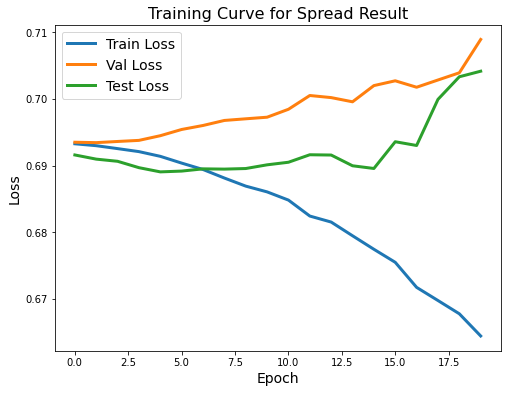

In [26]:
if(task == 'regression'):
    most_money = -99999
    best_threshold = 0
    moneys = []
    for t in np.linspace(0.9, 5, 51):
        print()
        result = regression_betting_result_lstm(model, val_loader, df, threshold=t)
        moneys.append(result[0])
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print(most_money, best_threshold)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(np.linspace(0.9, 5, 51), moneys, lw=3)
    ax.set_xlabel("Betting Threshold", fontsize=14)
    ax.set_ylabel("Money ($)", fontsize=14)
    ax.set_title("Money Made on 2021 Season vs. Betting Threshold", fontsize=16)
    plt.show()
    
    print("\n\nTEST")
    result = regression_betting_result_lstm(model, test_loader, df, threshold=best_threshold)
    money_made.append(result[0])
    games_bet.append(result[1])

print(trainloss[-1], testloss[-1])
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(trainloss, label="Train Loss", lw=3)
ax.plot(valloss, label="Val Loss", lw=3)
ax.plot(testloss, label="Test Loss", lw=3)
ax.legend(loc='best', fontsize=14)
ax.set_title("Training Curve for Spread Result", fontsize=16)
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
plt.show()

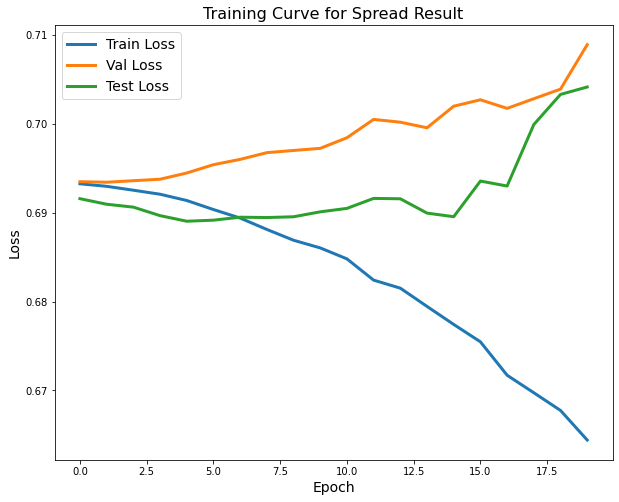

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(trainloss, label="Train Loss", lw=3)
ax.plot(valloss, label="Val Loss", lw=3)
ax.plot(testloss, label="Test Loss", lw=3)
ax.legend(loc='best', fontsize=14)
ax.set_title("Training Curve for Spread Result", fontsize=16)
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
plt.show()

In [28]:
if(task == 'classification'):
    print("CLASSIFICATION")
    most_money = -99999
    best_threshold = 0
    train_accuracy = evaluate_lstm(train_loader, model)
    val_accuracy = evaluate_lstm(val_loader, model)
    test_accuracy = evaluate_lstm(test_loader, model)
    for t in np.linspace(0.5, 1.0, 51):
        result = classification_betting_result_lstm(model, val_loader, df, threshold=t)
        if(result[0] > most_money):
            most_money = result[0]
            best_threshold = t
    print("\n\nTEST DATASET:")
    result = classification_betting_result_lstm(model, val_loader, df, threshold=best_threshold)
    
elif(task == 'regression'):
    result = regression_betting_result_lstm(model, val_loader, df, threshold=0.1)
    money_made.append(result[0])
    games_bet.append(result[1])
    result = regression_betting_result_lstm(model, test_loader, df, threshold=0.1)
    money_made.append(result[0])
    games_bet.append(result[1])

CLASSIFICATION
CLASSIFICATION ACCURACY: 61.600%
CLASSIFICATION ACCURACY: 51.215%
CLASSIFICATION ACCURACY: 54.406%


TEST DATASET:


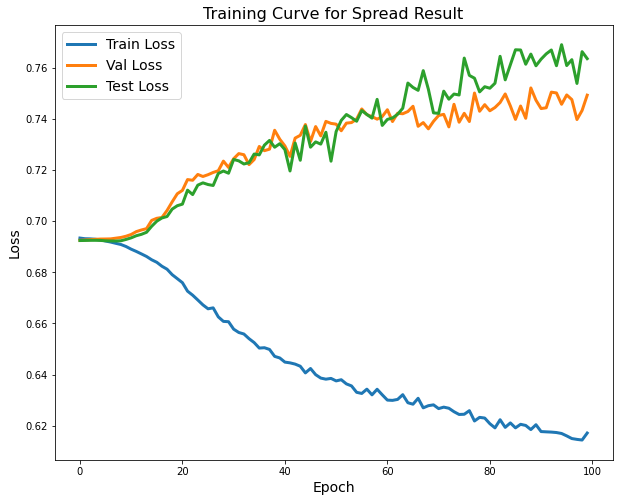

In [190]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(trainloss, label="Train Loss", lw=3)
ax.plot(valloss, label="Val Loss", lw=3)
ax.plot(testloss, label="Test Loss", lw=3)
ax.legend(loc='best', fontsize=14)
ax.set_title("Training Curve for Spread Result", fontsize=16)
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
plt.show()